In [45]:
import pandas as pd
import pyreadr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from utils.functions import forward_selection, backward_selection_aic,stepwise_selection_both,backward_selection_pvalue
from sklearn.metrics import mean_squared_error
from scipy.stats import shapiro

# EDA

In [46]:
df = pyreadr.read_r('precos.rds')[None]

In [47]:
df.head()

,SalePrice,Basement_Area,Lot_Area,Heating_QC,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
0,215000.0,1080.0,31770.0,Fa,2.0,1656.0,528.0,272.0,50.0,3.0,2.0
1,105000.0,882.0,11622.0,TA,3.0,896.0,730.0,260.0,49.0,2.0,1.0
2,172000.0,1329.0,14267.0,TA,3.0,1329.0,312.0,429.0,52.0,3.0,1.1
3,244000.0,2110.0,11160.0,Ex,2.0,2110.0,522.0,0.0,42.0,3.0,3.1
4,189900.0,928.0,13830.0,Gd,2.0,1629.0,482.0,246.0,13.0,3.0,2.1


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   SalePrice        2928 non-null   float64
 1   Basement_Area    2928 non-null   float64
 2   Lot_Area         2928 non-null   float64
 3   Heating_QC       2928 non-null   object 
 4   Season_Sold      2928 non-null   float64
 5   Gr_Liv_Area      2928 non-null   float64
 6   Garage_Area      2928 non-null   float64
 7   Deck_Porch_Area  2928 non-null   float64
 8   Age_Sold         2928 non-null   float64
 9   Bedroom_AbvGr    2928 non-null   float64
 10  Total_Bathroom   2928 non-null   float64
dtypes: float64(10), object(1)
memory usage: 251.8+ KB


In [49]:
df.describe()

,SalePrice,Basement_Area,Lot_Area,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
count,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000
mean,180841.033811,1051.680328,10149.730533,2.608265,1499.784495,472.885587,159.929645,36.409153,2.854508,2.042042
std,79889.904415,440.675942,7882.299902,0.900154,505.522007,215.053740,156.384644,30.285250,0.827859,0.756761
min,12789.000000,0.000000,1300.000000,1.000000,334.000000,0.000000,0.000000,-1.000000,0.000000,0.400000
25%,129500.000000,793.000000,7440.750000,2.000000,1126.000000,320.000000,22.000000,7.000000,2.000000,1.100000
50%,160000.000000,990.000000,9444.500000,3.000000,1442.000000,480.000000,140.000000,34.000000,3.000000,2.000000
75%,213500.000000,1302.000000,11556.000000,3.000000,1742.250000,576.000000,247.000000,54.000000,3.000000,2.100000
max,755000.000000,6110.000000,215245.000000,4.000000,5642.000000,1488.000000,1424.000000,136.000000,8.000000,6.200000


In [50]:
df_check = df[df['Age_Sold'] == -1]
df_check.head()

,SalePrice,Basement_Area,Lot_Area,Heating_QC,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
2179,183850.0,5095.0,39290.0,Ex,4.0,5095.0,1154.0,1030.0,-1.0,2.0,3.2


Temos uma informação de Age com número negativo, na coluna Age_Sold.
Como não conhecimento completo do negocio, optou-se por manter esse registro na base de dados

In [51]:
df.isnull().sum()

SalePrice          0
Basement_Area      0
Lot_Area           0
Heating_QC         0
Season_Sold        0
Gr_Liv_Area        0
Garage_Area        0
Deck_Porch_Area    0
Age_Sold           0
Bedroom_AbvGr      0
Total_Bathroom     0
dtype: int64

In [52]:
df.duplicated().sum()

np.int64(3)

Temos 8 registros duplicados na base de dados. Como tratam-se de casas, não há impedimento algum em termos casas totalmente iguais.
Portanto, optou-se também por manter os registros duplicados na base de dados.

In [53]:
df_duplicated = df[df.duplicated() == True]
df_duplicated

,SalePrice,Basement_Area,Lot_Area,Heating_QC,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
763,179000.0,1200.0,10800.0,TA,2.0,1200.0,0.0,120.0,22.0,3.0,6.0
811,118858.0,0.0,7018.0,TA,3.0,1535.0,400.0,0.0,30.0,4.0,2.0
2828,130000.0,970.0,2522.0,Ex,2.0,1709.0,380.0,40.0,2.0,3.0,2.0


In [54]:
df.columns

Index(['SalePrice', 'Basement_Area', 'Lot_Area', 'Heating_QC', 'Season_Sold',
       'Gr_Liv_Area', 'Garage_Area', 'Deck_Porch_Area', 'Age_Sold',
       'Bedroom_AbvGr', 'Total_Bathroom'],
      dtype='object')

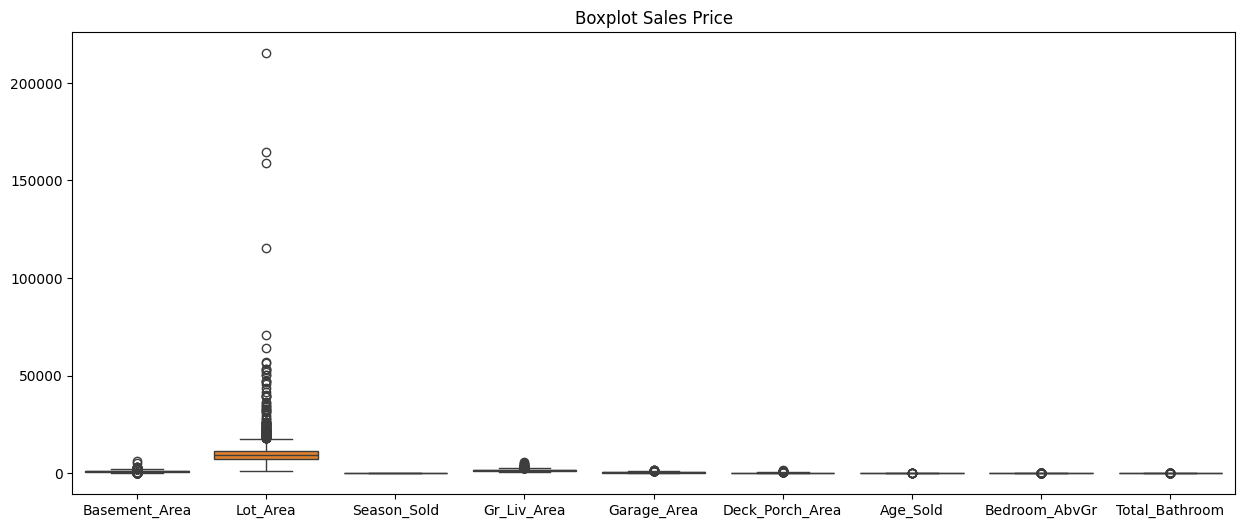

In [60]:
# Ajustar o tamanho da figura
plt.figure(figsize=(15, 6))

# Criar o boxplot para várias colunas
sns.boxplot(data=df.drop(columns='SalePrice'))  # Isso cria boxplots para todas as colunas numéricas

# Adicionar título
plt.title('Boxplot Sales Price')

# Exibir o gráfico
plt.show()

Percebe-se que a coluna Lot_Area está distorcendo todo o gráfico.

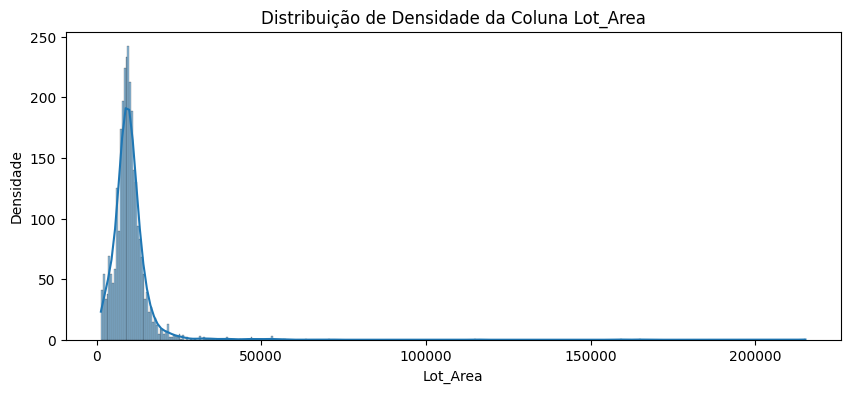

In [56]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x='Lot_Area', fill=True,kde=True)  # fill=True preenche a área abaixo da curva
plt.title('Distribuição de Densidade da Coluna Lot_Area')
plt.xlabel('Lot_Area')
plt.ylabel('Densidade')
plt.show()

Analisando exclusivamente a coluna de Lot_Area, percebe-se lotes com área maior que 50000.
Não há impedimento para o tamanho de um imovel.


Em seguida será analisado a dispersão dos valores excluindo a coluna com maiores outliers - Lot_Area.

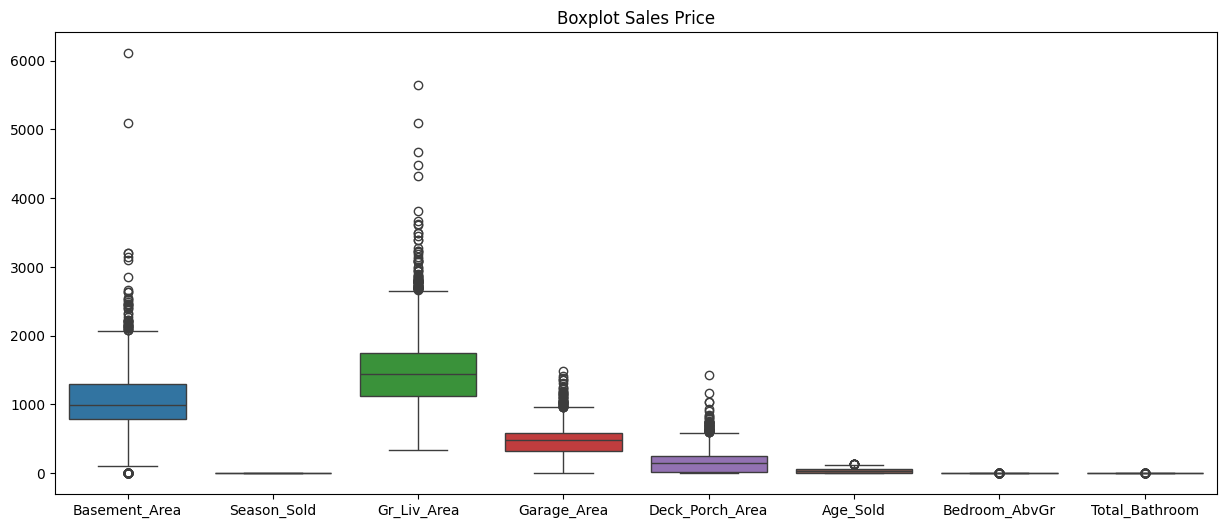

In [61]:
# Ajustar o tamanho da figura
plt.figure(figsize=(15, 6))

# Criar o boxplot para várias colunas
sns.boxplot(data=df.drop(columns=['Lot_Area','SalePrice']))  # Isso cria boxplots para todas as colunas numéricas

# Adicionar título
plt.title('Boxplot Sales Price')

# Exibir o gráfico
plt.show()

Não há registros que possam comprometer a elaboração do modelo de previsão de vendas.

# Analise de Multicolinearidade

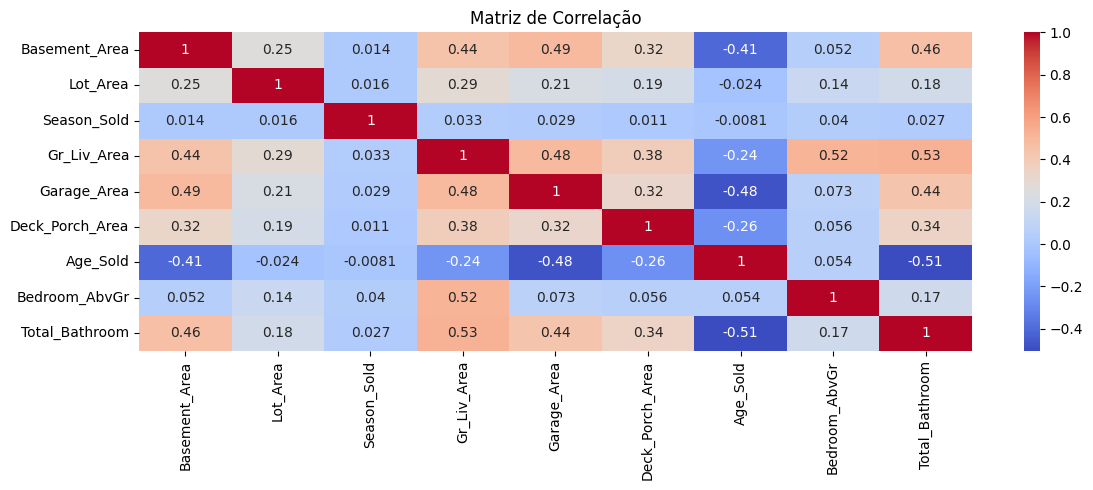

In [62]:
plt.figure(figsize=(12, 5))
correlation_matrix = df.drop(columns=['Heating_QC','SalePrice']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 10})

plt.title('Matriz de Correlação')

plt.tight_layout()
plt.show()

### Calculo do VIF

In [64]:
# 2. Separe as colunas independentes (X) e remova 'y'
X = df.drop(columns=['Heating_QC','SalePrice'])

# 3. Adicione a constante (intercepto) para o modelo
X = sm.add_constant(X)

# 4. Calcule o VIF para cada coluna (incluindo 'const')
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i)  
    for i in range(X.shape[1])
]

# 5. Calcule a Tolerância = 1 / VIF
vif_data["Tolerance"] = 1 / vif_data["VIF"]

# 6. Visualize o resultado
print(vif_data)

          Variable        VIF  Tolerance
0            const  38.069613   0.026268
1    Basement_Area   1.604083   0.623409
2         Lot_Area   1.143253   0.874697
3      Season_Sold   1.002522   0.997484
4      Gr_Liv_Area   2.488395   0.401866
5      Garage_Area   1.735759   0.576117
6  Deck_Porch_Area   1.274839   0.784413
7         Age_Sold   1.635505   0.611432
8    Bedroom_AbvGr   1.522690   0.656732
9   Total_Bathroom   1.820469   0.549309


Após calcular o VIF para todas as variáveis do modelo, verificou-se que nenhuma delas ultrapassou o valor de 5, o que indica que o risco de multicolinearidade é baixo e não compromete a estabilidade das estimativas dos coeficientes.

In [74]:
df_dum = pd.get_dummies(df,columns=['Heating_QC'],drop_first=True)
df_dum.head(10)

,SalePrice,Basement_Area,Lot_Area,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom,Heating_QC_Fa,Heating_QC_Gd,Heating_QC_Po,Heating_QC_TA
0,215000.0,1080.0,31770.0,2.0,1656.0,528.0,272.0,50.0,3.0,2.0,True,False,False,False
1,105000.0,882.0,11622.0,3.0,896.0,730.0,260.0,49.0,2.0,1.0,False,False,False,True
2,172000.0,1329.0,14267.0,3.0,1329.0,312.0,429.0,52.0,3.0,1.1,False,False,False,True
3,244000.0,2110.0,11160.0,2.0,2110.0,522.0,0.0,42.0,3.0,3.1,False,False,False,False
4,189900.0,928.0,13830.0,2.0,1629.0,482.0,246.0,13.0,3.0,2.1,False,True,False,False
5,195500.0,926.0,9978.0,3.0,1604.0,470.0,396.0,12.0,3.0,2.1,False,False,False,False
6,213500.0,1338.0,4920.0,2.0,1338.0,582.0,0.0,9.0,2.0,3.0,False,False,False,False
7,191500.0,1280.0,5005.0,1.0,1280.0,506.0,226.0,18.0,2.0,2.0,False,False,False,False
8,236500.0,1595.0,5389.0,2.0,1616.0,608.0,389.0,15.0,2.0,3.0,False,False,False,False
9,189000.0,994.0,7500.0,3.0,1804.0,442.0,200.0,11.0,3.0,2.1,False,True,False,False


# Modelo

In [69]:
features = df_dum.columns.drop(['SalePrice'])
formula = 'SalePrice ~' + '+'.join(features)
reg_mult = smf.ols(formula=formula,data=df_dum).fit()
print(reg_mult.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     722.3
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:53:35   Log-Likelihood:                -35098.
No. Observations:                2928   AIC:                         7.022e+04
Df Residuals:                    2914   BIC:                         7.031e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              4.232e+

In [76]:
features = df_dum.columns.drop(['SalePrice','Season_Sold'])
formula = 'SalePrice ~' + '+'.join(features)
reg_mult = smf.ols(formula=formula,data=df_dum).fit()
print(reg_mult.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.763
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     782.4
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        21:55:34   Log-Likelihood:                -35098.
No. Observations:                2928   AIC:                         7.022e+04
Df Residuals:                    2915   BIC:                         7.030e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              4.431e+

# Seleção Forward

In [87]:
df_forward = df.drop(columns=['Season_Sold','Heating_QC'])
df_forward.head()

,SalePrice,Basement_Area,Lot_Area,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
0,215000.0,1080.0,31770.0,1656.0,528.0,272.0,50.0,3.0,2.0
1,105000.0,882.0,11622.0,896.0,730.0,260.0,49.0,2.0,1.0
2,172000.0,1329.0,14267.0,1329.0,312.0,429.0,52.0,3.0,1.1
3,244000.0,2110.0,11160.0,2110.0,522.0,0.0,42.0,3.0,3.1
4,189900.0,928.0,13830.0,1629.0,482.0,246.0,13.0,3.0,2.1


In [88]:
forward_model, forward_vars = forward_selection(df_forward, response='SalePrice', significance_level=0.05)

print(forward_model.summary())
print("\nVariáveis selecionadas:", forward_vars)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1122.
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:01:54   Log-Likelihood:                -35149.
No. Observations:                2928   AIC:                         7.032e+04
Df Residuals:                    2919   BIC:                         7.037e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         3.68e+04   4070.624     

# Seleção Backward

In [89]:
df_backward = df.drop(columns=['Season_Sold','Heating_QC'])
df_backward.head()

,SalePrice,Basement_Area,Lot_Area,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
0,215000.0,1080.0,31770.0,1656.0,528.0,272.0,50.0,3.0,2.0
1,105000.0,882.0,11622.0,896.0,730.0,260.0,49.0,2.0,1.0
2,172000.0,1329.0,14267.0,1329.0,312.0,429.0,52.0,3.0,1.1
3,244000.0,2110.0,11160.0,2110.0,522.0,0.0,42.0,3.0,3.1
4,189900.0,928.0,13830.0,1629.0,482.0,246.0,13.0,3.0,2.1


In [91]:
# Ajusta o modelo por backward com critério AIC
backward_model, final_vars = backward_selection_aic(df_backward, response='SalePrice')

# Sumário do modelo final
print(backward_model.summary())

# Quais variáveis ficaram?
print("Variáveis no modelo final:", final_vars)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1122.
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:03:51   Log-Likelihood:                -35149.
No. Observations:                2928   AIC:                         7.032e+04
Df Residuals:                    2919   BIC:                         7.037e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         3.68e+04   4070.624     

# Seleção both

In [93]:
df_both = df.drop(columns=['Season_Sold','Heating_QC'])
df_both.head()

,SalePrice,Basement_Area,Lot_Area,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
0,215000.0,1080.0,31770.0,1656.0,528.0,272.0,50.0,3.0,2.0
1,105000.0,882.0,11622.0,896.0,730.0,260.0,49.0,2.0,1.0
2,172000.0,1329.0,14267.0,1329.0,312.0,429.0,52.0,3.0,1.1
3,244000.0,2110.0,11160.0,2110.0,522.0,0.0,42.0,3.0,3.1
4,189900.0,928.0,13830.0,1629.0,482.0,246.0,13.0,3.0,2.1


In [94]:
both_model, final_vars = stepwise_selection_both(
    data=df_both, 
    response='SalePrice',
    initial_list=None,       # ou alguma lista inicial de variáveis
    threshold_in=0.01,       # p-value threshold para incluir
    threshold_out=0.05,      # p-value threshold para remover
    verbose=True
)

print(both_model.summary())
print("Variáveis selecionadas:", final_vars)

 + Include Gr_Liv_Area with p-value 0.0000, AIC = 72390.38
 + Include Age_Sold with p-value 0.0000, AIC = 71269.95
 + Include Basement_Area with p-value 0.0000, AIC = 70771.21
 + Include Bedroom_AbvGr with p-value 0.0000, AIC = 70569.98
 + Include Garage_Area with p-value 0.0000, AIC = 70407.61
 + Include Deck_Porch_Area with p-value 0.0000, AIC = 70361.89
 + Include Total_Bathroom with p-value 0.0000, AIC = 70326.19
 + Include Lot_Area with p-value 0.0008, AIC = 70316.97
No further improvement.
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1122.
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:05:11   Log-Likelihood:                -35149.
No. Observations:        

# Seleção p_value

In [97]:
df_p_value = df.drop(columns=['Season_Sold','Heating_QC'])
df_p_value.head()

,SalePrice,Basement_Area,Lot_Area,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom
0,215000.0,1080.0,31770.0,1656.0,528.0,272.0,50.0,3.0,2.0
1,105000.0,882.0,11622.0,896.0,730.0,260.0,49.0,2.0,1.0
2,172000.0,1329.0,14267.0,1329.0,312.0,429.0,52.0,3.0,1.1
3,244000.0,2110.0,11160.0,2110.0,522.0,0.0,42.0,3.0,3.1
4,189900.0,928.0,13830.0,1629.0,482.0,246.0,13.0,3.0,2.1


In [98]:
pvalue_model, final_vars = backward_selection_pvalue(df_p_value, response='SalePrice', alpha=0.05, verbose=True)

print(pvalue_model.summary())
print("Variáveis remanescentes:", final_vars)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     1122.
Date:                Mon, 03 Feb 2025   Prob (F-statistic):               0.00
Time:                        22:06:31   Log-Likelihood:                -35149.
No. Observations:                2928   AIC:                         7.032e+04
Df Residuals:                    2919   BIC:                         7.037e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         3.68e+04   4070.624     

In [100]:
df['p_value'] = pvalue_model.predict(df_p_value)
df['backward'] = backward_model.predict(df_backward)
df['both'] = both_model.predict(df_both)
df['forward'] = forward_model.predict(df_forward)
df['residuos'] = df['SalePrice'] - df['forward']

In [102]:
df.head()

,SalePrice,Basement_Area,Lot_Area,Heating_QC,Season_Sold,Gr_Liv_Area,Garage_Area,Deck_Porch_Area,Age_Sold,Bedroom_AbvGr,Total_Bathroom,p_value,backward,both,forward,residuos
0,215000.0,1080.0,31770.0,Fa,2.0,1656.0,528.0,272.0,50.0,3.0,2.0,197472.107378,197472.107378,197472.107378,197472.107378,17527.892622
1,105000.0,882.0,11622.0,TA,3.0,896.0,730.0,260.0,49.0,2.0,1.0,141709.721120,141709.721120,141709.721120,141709.721120,-36709.721120
2,172000.0,1329.0,14267.0,TA,3.0,1329.0,312.0,429.0,52.0,3.0,1.1,159572.734878,159572.734878,159572.734878,159572.734878,12427.265122
3,244000.0,2110.0,11160.0,Ex,2.0,2110.0,522.0,0.0,42.0,3.0,3.1,266144.099270,266144.099270,266144.099270,266144.099270,-22144.099270
4,189900.0,928.0,13830.0,Gd,2.0,1629.0,482.0,246.0,13.0,3.0,2.1,203613.313379,203613.313379,203613.313379,203613.313379,-13713.313379


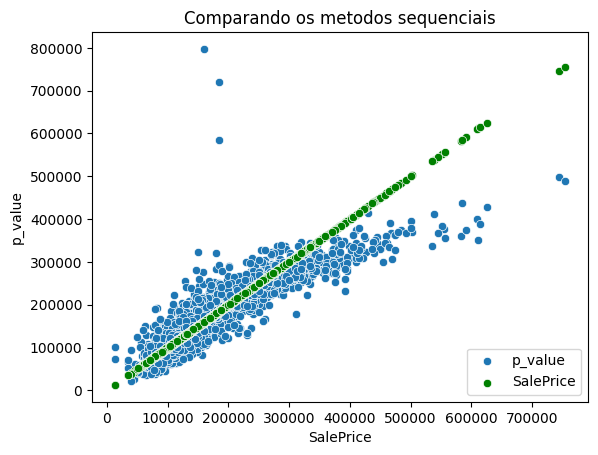

In [105]:
fig, ax = plt.subplots()
sns.scatterplot(data=df,x=df['SalePrice'],y=df['p_value'],ax=ax, label='p_value')
#sns.scatterplot(data=df,x=df['SalePrice'],y=df['backward'],ax=ax, label='backward',color='black')
sns.scatterplot(data=df,x=df['SalePrice'],y=df['SalePrice'],ax=ax, label='SalePrice',color='green')
#sns.scatterplot(data=df,x=df['SalePrice'],y=df['both'],ax=ax, label='both',color='red')

plt.title("Comparando os metodos sequenciais")
plt.show()

# Calculando RMSE

In [107]:

mse_forward = mean_squared_error(
    df['SalePrice'], 
    df['forward'], 
    )
print("RMSE - forward:", np.sqrt(mse_forward))


mse_backward = mean_squared_error(
    df['SalePrice'], 
    df['backward']
)
print("RMSE - backward:", np.sqrt(mse_backward))

mse_both = mean_squared_error(
    df['SalePrice'], 
    df['both']
)
print("RMSE - both:", np.sqrt(mse_both))

mse_pvalue = mean_squared_error(
    df['SalePrice'], 
    df['p_value']
)
print("RMSE - pvalue:", np.sqrt(mse_pvalue))

RMSE - forward: 39563.72097413494
RMSE - backward: 39563.720974134936
RMSE - both: 39563.720974134936
RMSE - pvalue: 39563.720974134936


# Analise de Residuos

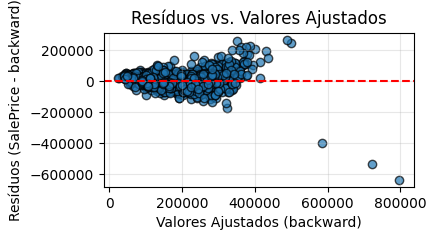

<Figure size 400x200 with 0 Axes>

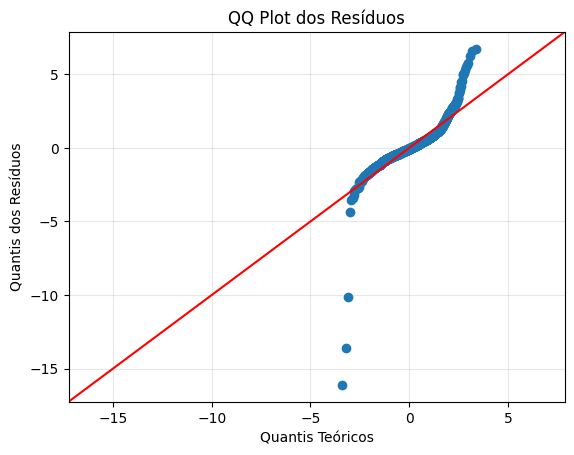

In [108]:
# Calculando os resíduos e valores ajustados
df['residuals'] = df['SalePrice'] - df['backward']  # Resíduos: Observado - Predito
valores_ajustados = df['backward']               # Valores ajustados
residuos = df['residuals']                     # Resíduos

# Gráfico 1: Resíduos vs. Valores Ajustados
plt.figure(figsize=(4, 2))
plt.scatter(valores_ajustados, residuos, alpha=0.7, edgecolor='k')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
plt.title("Resíduos vs. Valores Ajustados")
plt.xlabel("Valores Ajustados (backward)")
plt.ylabel("Resíduos (SalePrice - backward)")
plt.grid(alpha=0.3)
plt.show()

# Gráfico 2: QQ Plot dos Resíduos
plt.figure(figsize=(4, 2))
sm.qqplot(residuos, line='45', fit=True)
plt.title("QQ Plot dos Resíduos")
plt.ylabel("Quantis dos Resíduos")
plt.xlabel("Quantis Teóricos")
plt.grid(alpha=0.3)
plt.show()

In [109]:
# Teste de normalidade dos resíduos
residuos = df['residuals'] 
#Aplicando o teste de Shapiro-Wilk 
stat, p_value = shapiro(residuos) 
# Exibindo os resultados 
print(f"Estatística do teste: {stat}") 
print(f"P-valor: {p_value}") 

Estatística do teste: 0.8109715824470526
P-valor: 3.6446205237759907e-50


In [110]:
df['residuos'].mean()

np.float64(2.239245534594593e-10)

# Conclusão

Testes de seleção de variáveis foram aplicados e ambos praticamente deram os mesmos resultados.  
Os resultados de RMSE foram altos para todos os testes - ~39563,72.  
Apesar de a média dos resíduos apresentar média zero, os resíduos não apresentaram uma distribuição normal.  
Com esses resultado os modelos foram descartados.  
É sabido que temos tratativas para as variaveis, mas conhecimento será adquirido ao longo do curso